<a href="https://colab.research.google.com/github/ddomsondd/asl_atlas/blob/main/asl_atlas_project_efficientnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from pathlib import Path
import os.path
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [3]:
!kaggle datasets download -d grassknoted/asl-alphabet

Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
License(s): GPL-2.0


In [4]:
!unzip \*.zip && rm *.zip

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1909.jpg  
  inflating: a

In [5]:
import pandas as pd

def imgPaths(filepath):
  labels = [str(filepath[i]).split("/")[-2] \
  for i in range(len(filepath))]
  filepath = pd.Series(filepath, name='Filepath').astype(str)
  labels = pd.Series(labels, name='Label')

  df = pd.concat([filepath, labels], axis=1)

  df = df.sample(frac=1).reset_index(drop = True)
  return df

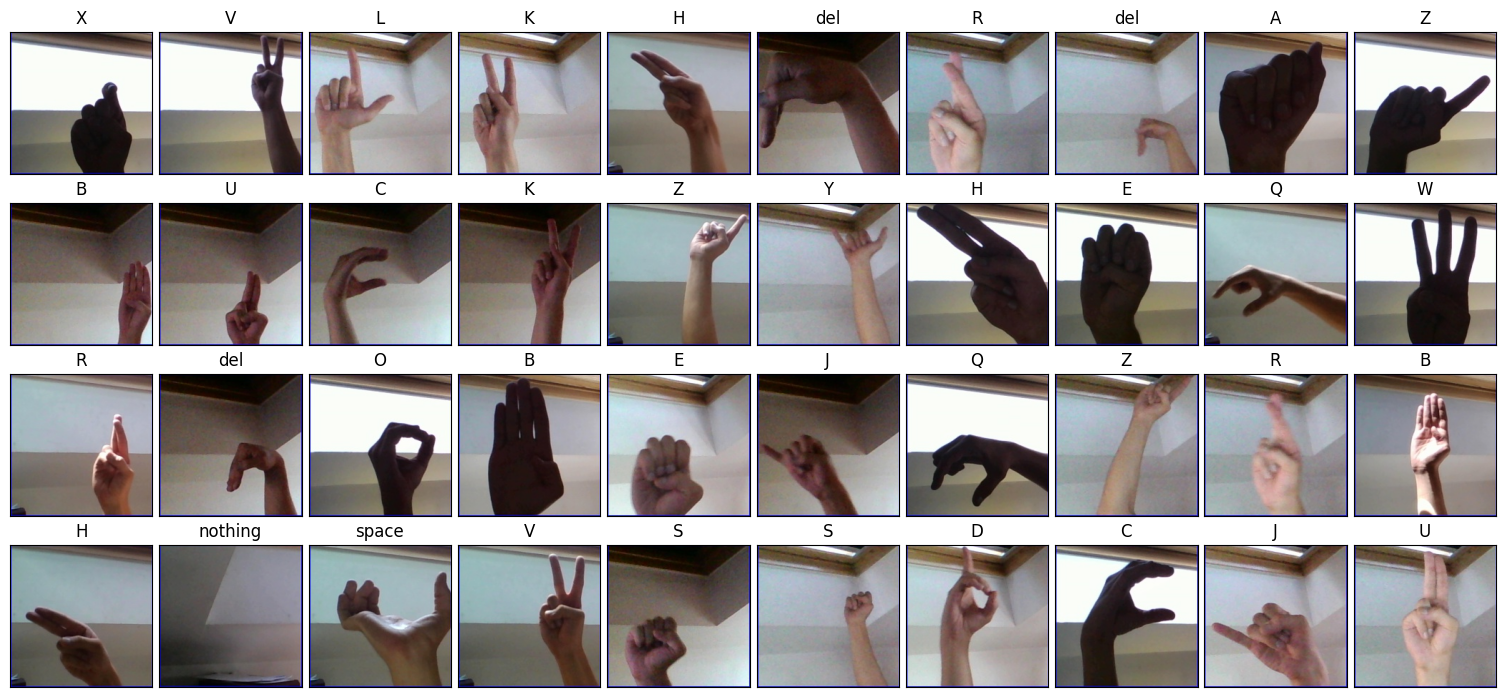

In [7]:
import matplotlib.pyplot as plt

image_path_dir = Path('/content/asl_alphabet_train')
image_path_list = list(image_path_dir.glob(r'**/*.jpg'))
images = imgPaths(image_path_list)

fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
  ax.imshow(plt.imread(images.Filepath[i]))
  ax.set_title(images.Label[i])
plt.tight_layout(pad=.5)
plt.show()

In [8]:
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

In [9]:
source_dir = '/content/asl_alphabet_train/asl_alphabet_train'

In [10]:
base_transform = transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.ToTensor()
])

In [11]:
full_dataset = datasets.ImageFolder(root=source_dir, transform=base_transform, target_transform=None)

In [12]:
def get_mean_and_std(loader):
  mean = 0.
  std = 0.
  total_images_count = 0

  for images, _ in loader:
    image_count_in_a_batch = images.size(0)
    images = images.view(image_count_in_a_batch, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    total_images_count += image_count_in_a_batch

  mean /= total_images_count
  std /= total_images_count

  return mean, std

In [13]:
from torch.utils.data import DataLoader
loader = DataLoader(full_dataset, batch_size=64, shuffle=False)

mean, std = get_mean_and_std(loader)

In [14]:
mean, std

(tensor([0.5187, 0.4988, 0.5147]), tensor([0.2017, 0.2310, 0.2390]))

In [15]:
train_transform = transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

test_transform = transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

In [16]:
train_dataset = datasets.ImageFolder(root=source_dir, transform=train_transform, target_transform=None)
test_dataset = datasets.ImageFolder(root=source_dir, transform=test_transform, target_transform=None)

In [17]:
import numpy as np

def show_transformed_images(dataset):
  loader = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=True)
  batch = next(iter(loader))
  images, labels = batch

  grid = torchvision.utils.make_grid(images, nrow=3)
  plt.figure(figsize=(11,11))
  plt.imshow(np.transpose(grid, (1,2,0)))
  print('labels: ', labels)

labels:  tensor([10, 17, 27, 18,  3, 27])


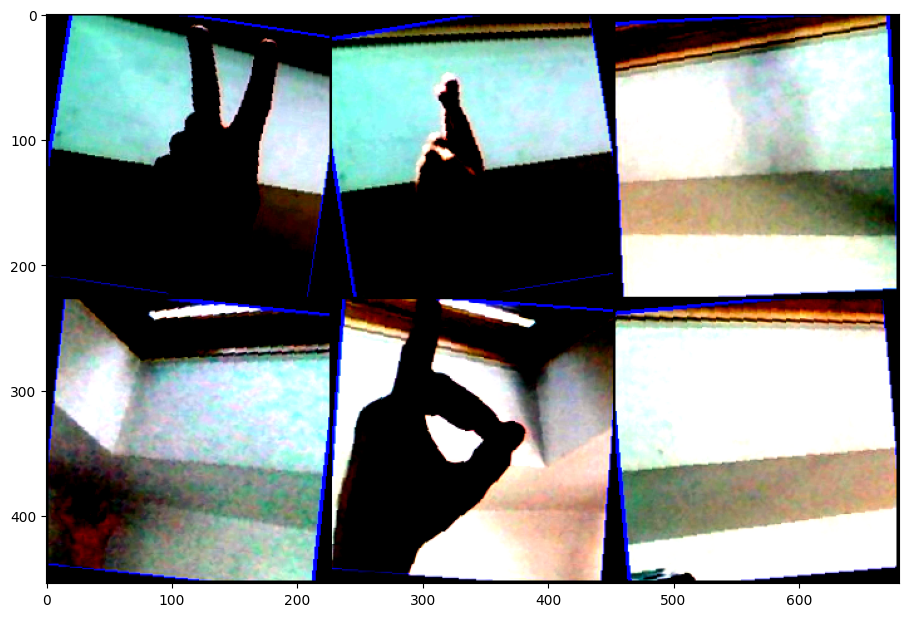

In [18]:
show_transformed_images(train_dataset)

In [ ]:
from torch.utils.data import random_split, Subset

train_size = int(len(full_dataset) * 0.8)
test_size = len(full_dataset) - train_size

generator = torch.Generator().manual_seed(42)
indices = torch.randperm(len(full_dataset), generator=generator).tolist()
train_indices = indices[:train_size]
test_indices = indices[train_size:]

train_dataset = Subset(train_dataset, train_indices)
test_dataset = Subset(test_dataset, test_indices)

print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}")

Train: 69600, Test: 17400


In [ ]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, num_workers=1, shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, num_workers=1, shuffle=False)

len(train_dataloader), len(test_dataloader)

(2175, 544)

In [ ]:
def set_device():
  if torch.cuda.is_available():
    dev = "cuda:0"
  else:
    dev = "cpu"
  return torch.device(dev)

In [ ]:
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
  device = set_device()

  results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

  for epoch in range(n_epochs):
    print(f"\nEpoch {epoch+1}/{n_epochs}")
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0

    for images, labels in train_loader:
      images = images.to(device)
      labels = labels.to(device)
      total += labels.size(0)

      optimizer.zero_grad()

      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      running_correct += (labels == predicted).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = running_correct / total

    test_loss, test_acc = evaluate_model(model, test_loader, criterion)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%")
    print(f"Test  Loss: {test_loss:.4f}, Test  Acc: {test_acc*100:.2f}%")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return model, results

In [ ]:
def evaluate_model(model, test_loader, criterion):
  model.eval()
  test_loss = 0.0
  correct = 0
  total = 0
  device = set_device()

  with torch.inference_mode():  #ewentualnie .no_grad()
    for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)

      loss = criterion(outputs, labels)
      test_loss += loss.item()

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  avg_loss = test_loss / len(test_loader)
  accuracy = correct / total
  return avg_loss, accuracy

In [ ]:
!pip install efficientnet_pytorch torchinfo

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.4 MB/s eta 0:00:00
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=a2e90e54b3046ad75c296bcee7e820fee74daf468abbf9c5

In [ ]:
from efficientnet_pytorch import EfficientNet
from torchinfo import summary
from torch import nn

num_classes = len(full_dataset.classes)
device = set_device()

model = EfficientNet.from_pretrained('efficientnet-b0').to(device)
num_features = model._fc.in_features

model._fc = nn.Linear(num_features, num_classes)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr=0.001)

summary(model=model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Loaded pretrained weights for efficientnet-b0


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 29]              --                   True
├─Conv2dStaticSamePadding (_conv_stem)                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    └─ZeroPad2d (static_padding)                            [1, 3, 224, 224]     [1, 3, 225, 225]     --                   --
├─BatchNorm2d (_bn0)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
├─MemoryEfficientSwish (_swish)                              [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
├─ModuleList (_blocks)                                       --                   --                   --                   True
│    └─MBConvBlock (0)                                       [1, 32, 112, 112]    [1, 16, 112, 1

Dodać timer:
from timeit import default_timer as timer
start_time = timer()

funkcja train

end_time = timer()

In [ ]:
from timeit import default_timer as timer
start_time = timer()

trained_model, model_results = train_nn(model, train_dataloader, test_dataloader, loss_fn, optimizer, 5)

end_time = timer()


Epoch 1/5
Train Loss: 0.0240, Train Acc: 99.29%
Test  Loss: 0.0190, Test  Acc: 99.44%

Epoch 2/5
Train Loss: 0.0202, Train Acc: 99.43%
Test  Loss: 0.2009, Test  Acc: 95.64%

Epoch 3/5
Train Loss: 0.0176, Train Acc: 99.48%
Test  Loss: 0.0147, Test  Acc: 99.57%

Epoch 4/5
Train Loss: 0.0103, Train Acc: 99.69%
Test  Loss: 0.0029, Test  Acc: 99.90%

Epoch 5/5
Train Loss: 0.0133, Train Acc: 99.61%
Test  Loss: 0.0159, Test  Acc: 99.63%


In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(results):
    # results dictionary
    loss = results['train_loss']
    test_loss = results['test_loss']
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 4))

    # plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

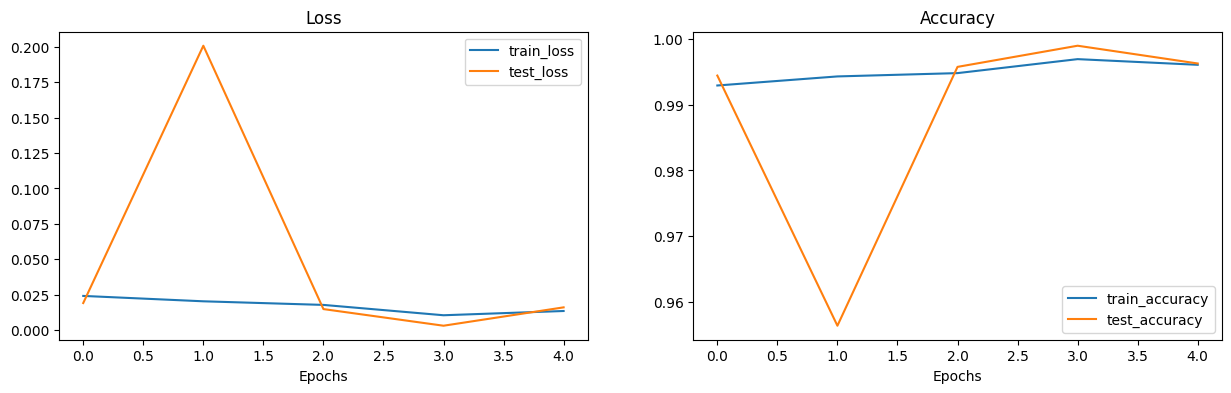

In [ ]:
plot_loss_curves(model_results)

In [ ]:
torch.save(trained_model.state_dict(), "efficientnet_asl.pth")

In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b0')
model._fc = nn.Linear(model._fc.in_features, num_classes)
model.load_state_dict(torch.load("efficientnet_asl.pth"))
model.eval()

Loaded pretrained weights for efficientnet-b0


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    